# Known concepts in the mechanism


# Simulation in Brian2

Importing the Brian package and setting up matplotlib for IPython:

In [1]:
from brian2 import *
from DynapSE import DynapSE
from SpikeGen import *

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90


from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

# Monitoring Output Frequency for Adaptation to different frequencies.
# SpikeGenerator - Neuron

In [2]:
def SFA(Iahp_th_bias,Iahp_tau_bias,Ica_bias):    
    device.reinit()
    device.activate()
    defaultclock.dt = 20 * us

    ## Observing Adaptation Effect
    ##################

    '''''
    input_type   = 'regular' # 'regular', 'poisson' or 'cosine' (Default: poisson)
    pulse_start  = 0         # second - Start time of input (Default: 0)
    pulse_stop   = 1         # second - Stop time of input (Default: 5)
    inp_duration = 1        # second - Simulation duration (Default: 5)
    rate         = 1000 # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine)
    N_generators            = 1 #number of generators 
    times        = int(inp_duration/ms) #used for later plotting
    '''''


    freq_list=[200,300,500,1000]*Hz
    inp_duration=1

    # Create a Brian2 network and chip instance and neurons-
    network = Network()
    chip = DynapSE(network)
    DPI_neurons  = chip.get_neurons(len(freq_list), 'Core_1')

    DPI_synapses=[]
    Spike_Generators=[]
    counter1=0
    counter2=1

    # Connect a single spike generator to a single DPI neuron 
    for i in range(len(freq_list)):
        Spike_Generators.append(SpikeGen('regular',0,1,1,freq_list[i],1,'SpikeGenerator'+str(i)))
        DPI_synapses.append(chip.add_connection(Spike_Generators[i],DPI_neurons[counter1:counter2], synapse_type='AMPA'))
        chip.connect(DPI_synapses[i], True)
        DPI_synapses[i].weight = 1
        DPI_synapses[i].d = 0
        counter1=counter1+1
        counter2=counter2+1
        


    # Using paramGen, set adaptation configurations for Core #1
    # In DynapSE, parames are set per Core.
    # In samna, this command is like: set_param(core_id, param_name, fine_value, coarse_value)


    ampa_conf = {"I_tau_syn_ampa": 5 * pA,
                "I_g_syn_ampa": 5 * pA,
                "I_wo_syn_ampa": 100 * pA}



    adaptation_conf = {
                    "Itau" : 2 * pA,
                    "Ith"  : 10 * pA,                   
                    "Itauahp": Iahp_tau_bias * pA,                 
                    "Ithahp": Iahp_th_bias * pA,

                    "Ica" : Ica_bias * pA
                    }


    # merge the param dict into 1.
    core_conf = {**ampa_conf,**adaptation_conf}
    # set the params
    chip.set_bias(core_conf, 'Core_1')

    # Monitors
    #mon_neuron_output = SpikeMonitor(DPI_neurons, name='mon_neuron_output')
    mon_adapt_state  = StateMonitor(DPI_neurons,  'Iahp', record=True)
    #mon_mem_state  = StateMonitor(DPI_neurons,  'Imem', record=True)
    network.add([Spike_Generators, DPI_neurons, DPI_synapses,mon_adapt_state])
    # Simulation
    network.run(inp_duration * 600 * ms)
    return mon_adapt_state




In [3]:
def graph_SFA(mon_adapt_state,i,k,j):
    
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[0].Iahp/pA)
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[1].Iahp/pA)
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[2].Iahp/pA)
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[3].Iahp/pA)
    ax.set_title('SFA Iahp_tau='+str(i)+'pA Iahp_th='+str(k)+'pA'+'pA ca='+str(j)+'pA')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Current (PA)')
    


4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
4 neurons are allocated f

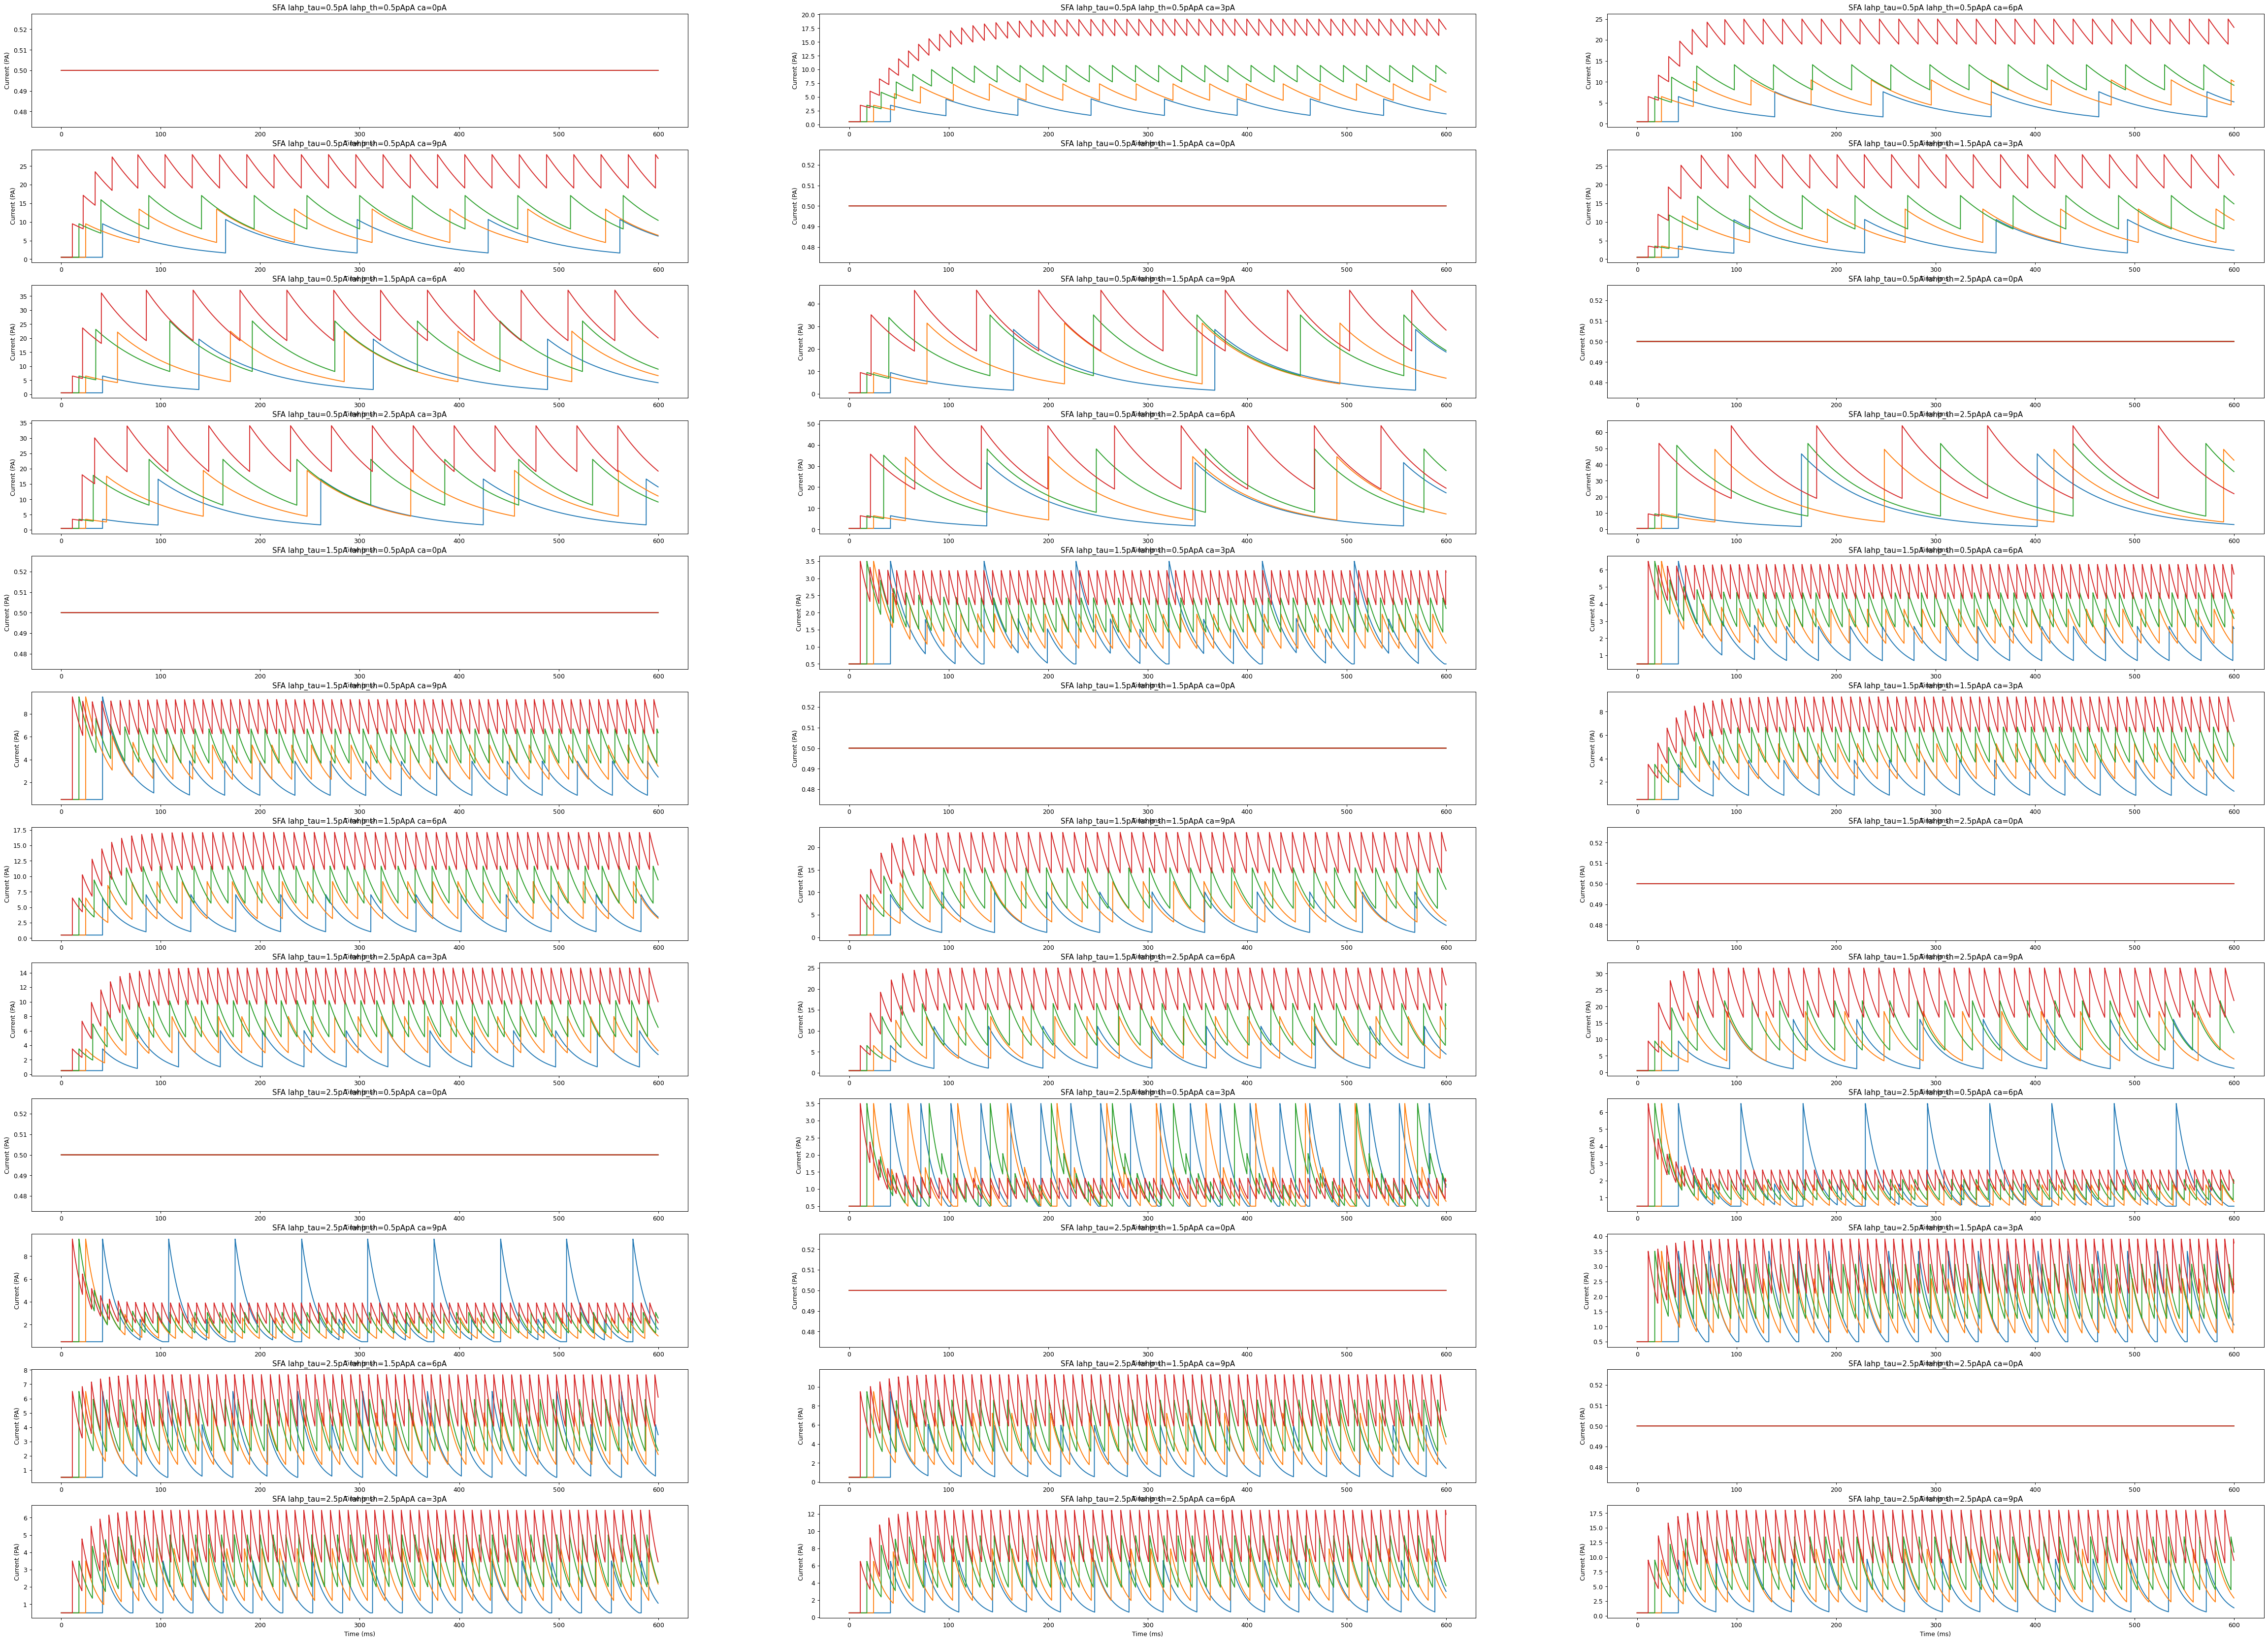

In [4]:
import math

import matplotlib.pyplot as plt
from matplotlib import gridspec


Iahp_th_list=np.arange(0.5,3.5,1)
Iahp_tau_list=np.arange(0.5,3.5,1)
I_CA_list=np.arange(0,12,3)

N = len(Iahp_tau_list)*len(Iahp_th_list)*len(I_CA_list)+1
cols = 3
rows = int(math.ceil(N / cols))

counter=1


scale = max(cols, rows)
fig = plt.figure(figsize=(5 * scale, 4 * scale))
for i in Iahp_tau_list:
    for k in Iahp_th_list:
        for j in I_CA_list:
            mon_adapt_state=SFA(k,i,j)
            ax = fig.add_subplot(rows,cols,counter)
            graph_SFA(mon_adapt_state,i,k,j)
            counter=counter+1
        




In [5]:
ax = fig.add_subplot(rows,cols,counter)
ax.plot([0,1,0], [0,1,0], 'k.')
ax.text(0, .7, 'Neural Constants: Iconst default, Itau 2 pA, Ith 10 pA, Ica 3 pA', style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
ax.text(0, .2, 'Smpa Synapse Constants: Itau 5 pA, Ig 5 pA, Iwo 100pA ', style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
fig.tight_layout()
fig.savefig('Trail3.jpeg')

In [ ]:
import math

import matplotlib.pyplot as plt
from matplotlib import gridspec

def do_plot(ax):
    ax.plot([1,2,3], [4,5,6], 'k.')


N = 11
cols = 3
rows = int(math.ceil(N / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()fig.plt.
for n in range(N):
    ax = fig.add_subplot(gs[n])
    do_plot(ax)

fig.tight_layout()

In [ ]:
np.arange(10,70,10)

In [ ]:
adapt_200=np.load("adapt_200.npy",allow_pickle=True)
adapt_300=np.load("adapt_300.npy",allow_pickle=True)
adapt_500=np.load("adapt_500.npy",allow_pickle=True)
adapt_1000=np.load("adapt_1000.npy",allow_pickle=True)


In [ ]:
# Confronting
# Time of interest
tstart = 0 # ms 
tend   = 1000 # ms


plot(adapt_200.item().get('t')[tstart*s:tend*s], adapt_200.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='y',label='$I_{ahp}$ 200 Hz')
plot(adapt_300.item().get('t')[tstart*s:tend*s], adapt_300.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='g',label='$I_{ahp}$ 300 Hz')
plot(adapt_500.item().get('t')[tstart*s:tend*s], adapt_500.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='b',label='$I_{ahp}$ 500 Hz')
plot(adapt_1000.item().get('t')[tstart*s:tend*s], adapt_1000.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='r',label='$I_{ahp}$ 1000 Hz')


plt.title('Adaptation Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.legend(loc='best')
plt.show()

In [ ]:
# Plotting output ISI
plot(np.diff(adapt_200.item().get('Output')),'oy',label='ISI 200 Hz')
plot(np.diff(adapt_300.item().get('Output')),'og',label='ISI 300 Hz')
plot(np.diff(adapt_500.item().get('Output')),'ob',label='ISI 500 Hz')
plot(np.diff(adapt_1000.item().get('Output')),'or',label='ISI 1000 Hz')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Spike number')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)




plt.subplot(4,1,1)

plot(adapt_200.item().get('t'), adapt_200.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 200 Hz')
plt.title('$I_{mem}$ 200 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')

plt.subplot(4,1,2)

plot(adapt_300.item().get('t'), adapt_300.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 300 Hz')
plt.title('$I_{mem}$ 300 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')

plt.subplot(4,1,3)
plot(adapt_500.item().get('t'), adapt_500.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 500 Hz')
plt.title('$I_{mem}$ 500 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')

plt.subplot(4,1,4)
plot(adapt_1000.item().get('t'), adapt_1000.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 1000 Hz')
plt.title('$I_{mem}$ 1000 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')
plt.xlabel('Time (ms)')




In [ ]:
##################
#  TODO: Change tstart and tend to find the time window that shows spike-frequency adaptation.
#
# Parameters
tstart = 0 # ms - 
tend   = 100 # ms -
##################


# Plotting
spike_placeholder = np.zeros(inp_duration*1000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=2

spike_placeholder2 = np.zeros(inp_duration*1000)
spike_placeholder2[np.array(mon_neuron_output.t/ms, dtype=int)]=3

s = int(1*ms / defaultclock.dt)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (ms)')
ax1.plot(spike_placeholder,'k.')
plt.yticks(np.arange(1, 5), ['a','Input Spikes','Output Spikes','d'])
ax1.tick_params(axis='y')
plt.ylim(1.5, 3.5)
plt.xlim(tstart,tend)
ax2 = ax1.twinx()  
ax1.plot(spike_placeholder2,'k.')

ax2.set_ylabel('Adaptation Current (A)', color='r')  
ax2.plot(mon_adapt_state.t/ms, mon_adapt_state.Iahp[0], linewidth=1.5,color='r', label='$I_{ahp}$')
ax2.tick_params(axis='y', labelcolor='r')
plt.xlim(tstart,tend)


fig.tight_layout()
plt.grid(True)

ax2.plot(mon_mem_state.t/ms, mon_mem_state.Imem[0], linewidth=1.5, color='g',label='$I_{mem}$')
plt.legend(loc='best')
plt.show()

In [ ]:
##################
#  TODO: Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay. 
#  Why do you think the amount of current at each input spike are not exactly same?
#
# Parameters
tstart = 0 # ms 
tend   = 100 # ms
##################

# Plotting
fig, ax1 = plt.subplots(figsize=(10,4))
fig.suptitle('Synaptic Currents')
s = int(1*ms / defaultclock.dt)

ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5, label='$I_{syn}$')
ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, DPI_synapse.Iampamax*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))[tstart*s:tend*s], 'C1--',label='Analytic')
ax1.legend()
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)


In [ ]:
print('Input firing rate = ', mon_neuron_input.count/ (inp_duration* 1000 * ms))
print('Output firing rate = ', mon_neuron_output.count/ (inp_duration* 1000 * ms))
print('number of input spikes',mon_neuron_input.count[0])
print('number of output spikes',mon_neuron_output.count[0])
print('maximum value of Isyn',DPI_synapse.Iampamax[0])
print('steady state value of Isyn',DPI_synapse.I_syn_ampa[0])
print('The maximum adaptation current is', DPI_neuron.Iahpmax[0])
print('steady state value of Iahp',DPI_neuron.Iahp[0])
print('time constant of Iahp', DPI_neuron.tauahp[0])
print('time constant of Isyn', DPI_synapse.tau_syn_exc2[0])
print('time constant of Imem', DPI_neuron.tau[0])

In [ ]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(inp_duration/ms)

# Input Spikes 
plt.subplot(4,1,1)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(4,1,2)
Imem = mon_mem_state.Imem[0]
plt.plot(mon_mem_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(4,1,3)
plot(mon_adapt_state.t/ms, mon_adapt_state.Iahp[0], linewidth=1.5,color='r')
plot(mon_adapt_state.t/ms, DPI_neuron.Iahpmax*(1-exp(-mon_adapt_state.t/DPI_neuron.tauahp)), 'C1--',label='Analytic')
plt.title('Adaptation Current')
plt.ylabel('Current (A)')


plt.subplot(4,1,4)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')



In [ ]:
##################
#  TODO: Play with tstart and tend to observe membrane current fluctuations and the moments of spike output.
#        Notice that the membrane current is more smoother than its synaptic input.
#
# Parameters
tstart = 0 # ms  
tend   = 100 # ms 
##################

# Plotting
s = int(1*ms / defaultclock.dt)
plt.figure(figsize=(4,2),dpi=150)
plt.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_mem_state.Imem[0][tstart*s:tend*s], linewidth=1.5)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='r', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (ms)')
plt.grid(True)

In [ ]:
# Time of interest
tstart = 0 # ms 
tend   = 150 # ms

Iahp_theor = DPI_neuron.Iahpmax*(1-exp(-mon_adapt_state.t/DPI_neuron.tauahp))
Iin_theor = DPI_synapse.Iampamax*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))

plot(mon_adapt_state.t[tstart*s:tend*s]/ms, mon_adapt_state.Iahp[0][tstart*s:tend*s], linewidth=1.5,color='r', label='$I_{ahp}$')
plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5, label='$I_{in}$')
plot(mon_mem_state.t/ms, mon_mem_state.Imem[0], linewidth=1.5, color='g',label='$I_{mem}$')
plt.title('Input Current Vs. Adaptation Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.xlim(tstart,tend)
plt.legend(loc='best')
plt.show()

In [ ]:
# Time of interest
tstart = 0 # ms 
tend   = 200 # ms

Iahp_theor = DPI_neuron.Iahpmax*(1-exp(-mon_adapt_state.t/DPI_neuron.tauahp))
Iin_theor = DPI_synapse.Iampamax*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))
diff_theor = Iin_theor - Iahp_theor

plot(mon_adapt_state.t[tstart*s:tend*s]/ms, Iahp_theor[tstart*s:tend*s], 'C1--',label='Analytic $I_{ahp}$')
plot(mon_mem_state.t[tstart*s:tend*s]/ms, Iin_theor[tstart*s:tend*s], 'C2--',label='Analytic $I_{in}$')
plot(mon_mem_state.t[tstart*s:tend*s]/ms, diff_theor[tstart*s:tend*s], 'C3--',label='Analytic $I_{mem}$')

plt.title('Input Current Vs. Adaptation Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.legend(loc='best')
plt.show()

In [ ]:
# Plotting output ISI
plot(np.diff(mon_neuron_output.t/ms),'o')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Spike number')
plt.grid(True)